In [1]:
import scanpy as sc
import pandas as pd
import flowsig as fs

2025-05-12 20:20:06.117158: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 20:20:06.129534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747052406.144782 2225132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747052406.149332 2225132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747052406.161097 2225132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [29]:
adata = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/epi/epi_counts.h5ad')
adata = adata.copy()
tissue = ['tumor_middle','tumor_edge','normal_adjacent']
adata = adata[adata.obs['Tissue'].isin(tissue)]
adata

View of AnnData object with n_obs × n_vars = 20822 × 17317
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', 'Epithelium_type', 'Detailed_Epithelium_type', 'Detailed_Tissue', 'Detailed_Epithelium_Type'
    var: 'is_highly_variable-2', 'mito-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Dataset_colors', 'Epithelium_type_colors', 'dendrogram_Epithelium_type', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scanvi_fix', 'X_scanvi_fix_linear', 'X_scanvi_no_fix', 'X_scvi', 'X_umap', '_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [30]:
cellchat_tumor_middle = pd.read_csv('/home/data/sdzl14/NSCLC/zong/epi/cellchat/tumor_middle/df.net.csv')
cellchat_tumor_edge = pd.read_csv('/home/data/sdzl14/NSCLC/zong/epi/cellchat/tumor_edge/df.net.csv')
cellchat_tumor_normal_adjacent = pd.read_csv('/home/data/sdzl14/NSCLC/zong/epi/cellchat/normal_adjacent/df.net.csv')
cellchat_output_key = 'cellchat_output'
# Make sure your keys for these align with their condition labels
adata.uns[cellchat_output_key] = {'tumor_middle': cellchat_tumor_middle,
                                  'tumor_edge': cellchat_tumor_edge,
                                  'normal_adjacent':cellchat_tumor_normal_adjacent}

In [31]:
adata

AnnData object with n_obs × n_vars = 20822 × 17317
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', 'Epithelium_type', 'Detailed_Epithelium_type', 'Detailed_Tissue', 'Detailed_Epithelium_Type'
    var: 'is_highly_variable-2', 'mito-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Dataset_colors', 'Epithelium_type_colors', 'dendrogram_Epithelium_type', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups', 'umap', 'cellchat_output'
    obsm: 'X_pca', 'X_scanvi_fix', 'X_scanvi_fix_linear', 'X_scanvi_no_fix', 'X_scvi', 'X_umap', '_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [32]:
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True, inplace=False)
sc.pp.log1p(adata, copy=False)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger', inplace=False)
sc.pp.scale(adata, max_value=10, copy=False)

In [33]:
# We construct 10 gene expression modules using the raw cell count.
condition_key = 'Tissue'
fs.pp.construct_gems_using_pyliger(adata,
                                n_gems = 10,
                                layer_key = 'counts',
                                condition_key = condition_key)

Removing 74 genes not expressing in normal_adjacent.
Removing 880 genes not expressing in tumor_edge.
Removing 748 genes not expressing in tumor_middle.


100%|██████████| 30/30 [03:18<00:00,  6.62s/it]


In [34]:
fs.pp.construct_flow_expressions(adata,
                                cellchat_output_key=cellchat_output_key,
                                model_organism = 'human',
                                spatial = False,
                                method = 'cellchat'
                                )

In [35]:
fs.pp.determine_informative_variables(adata,  
                                    spatial = False,
                                    condition_key = 'Tissue',
                                    control='tumor_middle',
                                    qval_threshold = 0.05,
                                    logfc_threshold = 0.5)

... storing 'Type' as categorical
... storing 'Downstream_TF' as categorical


... storing 'Type' as categorical
... storing 'Downstream_TF' as categorical


In [18]:
adata.X = adata.layers['counts']

In [21]:
adata.obs['Tissue']

ACTATCTCAAGGGTCA.2.NEC-2-2    normal_adjacent
AGACGTTGTCCAGTAT.2.NEC-2-2    normal_adjacent
CACAGTAGTCAAGCGA.2.NEC-2-2    normal_adjacent
CCGGGATGTACCGTAT.2.NEC-2-2    normal_adjacent
CCTACACAGTATTGGA.2.NEC-2-2    normal_adjacent
                                   ...       
ASK452_AATTAACGTAGA-19-2      normal_adjacent
ASK452_TTACGGTCTAAA-19-2      normal_adjacent
ASK454_TATCACTAAGAT-19-2      normal_adjacent
ASK452_ATTTCGTAGTGA-19-2      normal_adjacent
ASK454_GCAGTTATGTCG-19-2      normal_adjacent
Name: Tissue, Length: 20822, dtype: category
Categories (3, object): ['normal_adjacent', 'tumor_edge', 'tumor_middle']

In [37]:
fs.tl.learn_intercellular_flows(adata,
                        condition_key = condition_key,
                        control = 'tumor_middle', 
                        use_spatial = False,
                        n_jobs = 1,
                        n_bootstraps = 20)

Starting 20 bootstraps on 1 cores …


100%|██████████| 20/20 [00:08<00:00,  2.27it/s]

Finished in 8.8 s


In [38]:
fs.tl.apply_biological_flow(adata,
                        flowsig_network_key = 'flowsig_network',
                        adjacency_key = 'adjacency',
                        validated_key = 'adjacency_validated')

edge_threshold = 0.7

fs.tl.filter_low_confidence_edges(adata,
                                edge_threshold = edge_threshold,
                                flowsig_network_key = 'flowsig_network',
                                adjacency_key = 'adjacency',
                                filtered_key = 'adjacency_filtered')

In [39]:
adata

AnnData object with n_obs × n_vars = 20822 × 17317
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', 'Epithelium_type', 'Detailed_Epithelium_type', 'Detailed_Tissue', 'Detailed_Epithelium_Type'
    var: 'is_highly_variable-2', 'mito-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Dataset_colors', 'Epithelium_type_colors', 'dendrogram_Epithelium_type', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups', 'umap', 'cellchat_output', 'pyliger_info', 'flowsig_network', 'flowsig_network_orig'
    obsm: 'X_pca', 'X_scanvi_fix', 'X_scanvi_fix_linear', 'X_scanvi_no_fix', 'X_scvi', 'X_umap', '_latent', 'X_gem', 'X_flow', 'X_flow_orig'
    layers: 'counts'
    obsp: 'connectivities', 'd

... storing 'Type' as categorical
... storing 'Downstream_TF' as categorical


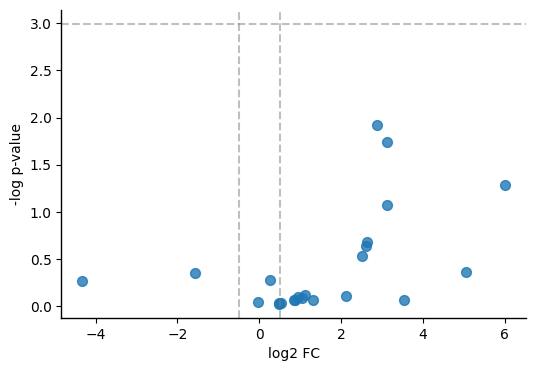

In [40]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
fs.pl.plot_differentially_flowing_signals(adata,
                                        condition_key = 'Tissue',
                                        pert_key = 'tumor_edge',
                                        var_type = 'outflow',
                                        flowsig_expr_key = 'X_flow_orig',
                                        flowsig_network_key = 'flowsig_network_orig',
                                        qval_threshold = 0.05,
                                        logfc_threshold = 0.5,
                                        label_lowqval = True,
                                        ax=ax
                                        )
plt.show()

In [41]:
fs.tl.learn_intercellular_flows(adata,
                        condition_key = condition_key,
                        control = 'tumor_middle', 
                        use_spatial = False,
                        n_jobs = 4,
                        n_bootstraps = 500)

Starting 500 bootstraps on 4 cores …


  0%|          | 0/500 [00:00<?, ?it/s]2025-05-13 08:53:22.279554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 08:53:22.292021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747097602.307288 2309001 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747097602.311810 2309001 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747097602.323453 2309001 computation_placer.cc:177] computation placer already registered. 

Finished in 134.8 s


In [44]:
fs.tl.apply_biological_flow(adata,
                            adjacency_key = 'adjacency',
                            validated_key = 'validated')
edge_threshold = 0.7
fs.tl.filter_low_confidence_edges(adata,
                                edge_threshold = edge_threshold,
                                adjacency_key = 'adjacency_validated',
                                filtered_key = 'filtered')

In [45]:
flow_network = fs.tl.construct_intercellular_flow_network(adata,
                                                        flowsig_network_key = 'flowsig_network',
                                                        adjacency_key = 'adjacency_validated_filtered')

In [63]:
print(type(adata.uns['flowsig_network_orig']))
print(adata.uns['flowsig_network_orig'])

<class 'dict'>
{'flow_var_info':            Type Downstream_TF  \
TGFB2   outflow                 
TGFB3   outflow                 
BMP2    outflow                 
BMP4    outflow                 
GDF15   outflow                 
...         ...           ...   
GEM-6    module                 
GEM-7    module                 
GEM-8    module                 
GEM-9    module                 
GEM-10   module                 

                                              Interaction  
TGFB2   TGFB2 - (TGFBR1+TGFBR2)/TGFB2 - (ACVR1B+TGFBR2...  
TGFB3   TGFB3 - (TGFBR1+TGFBR2)/TGFB3 - (ACVR1B+TGFBR2...  
BMP2    BMP2 - (BMPR1B+ACVR2A)/BMP2 - (BMPR1B+ACVR2B)/...  
BMP4    BMP4 - (BMPR1B+ACVR2A)/BMP4 - (BMPR1B+ACVR2B)/...  
GDF15                                      GDF15 - TGFBR2  
...                                                   ...  
GEM-6                                                      
GEM-7                                                      
GEM-8                         

In [69]:
flow_var_info

{'flow_var_info':            Type Downstream_TF  \
 TGFB2   outflow                 
 TGFB3   outflow                 
 BMP2    outflow                 
 BMP4    outflow                 
 GDF15   outflow                 
 ...         ...           ...   
 GEM-6    module                 
 GEM-7    module                 
 GEM-8    module                 
 GEM-9    module                 
 GEM-10   module                 
 
                                               Interaction  
 TGFB2   TGFB2 - (TGFBR1+TGFBR2)/TGFB2 - (ACVR1B+TGFBR2...  
 TGFB3   TGFB3 - (TGFBR1+TGFBR2)/TGFB3 - (ACVR1B+TGFBR2...  
 BMP2    BMP2 - (BMPR1B+ACVR2A)/BMP2 - (BMPR1B+ACVR2B)/...  
 BMP4    BMP4 - (BMPR1B+ACVR2A)/BMP4 - (BMPR1B+ACVR2B)/...  
 GDF15                                      GDF15 - TGFBR2  
 ...                                                   ...  
 GEM-6                                                      
 GEM-7                                                      
 GEM-8                  

In [68]:
flow_var_info = adata.uns['flowsig_network_orig']
flow_var_info.to_dict()

AttributeError: 'dict' object has no attribute 'to_dict'

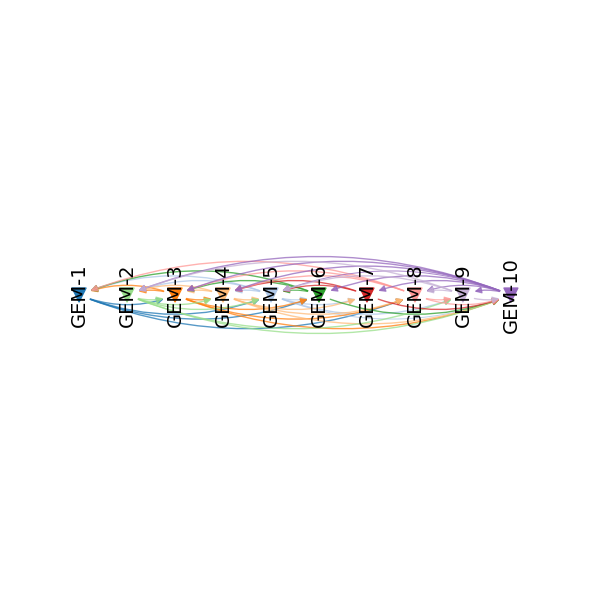

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
fs.pl.plot_intercellular_flows(adata,
                                flow_network = flow_network,
                                flowsig_network_key = 'flowsig_network',
                                align_mode = 'horizontal',
                                width_scale = 1.0,
                                x_margin_offset = 0.1,
                                y_margin_offset = 0.0,
                                ax=ax)
plt.show()

In [72]:
flow_network

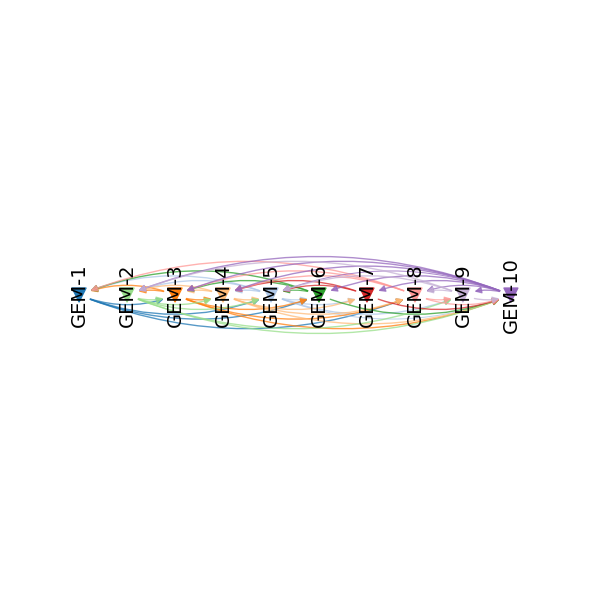

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
fs.pl.plot_intercellular_flows(adata,
                                flow_network = flow_network,
                                flowsig_network_key = 'flowsig_network',
                                align_mode = 'horizontal',
                                width_scale = 1.0,
                                x_margin_offset = 0.1,
                                y_margin_offset = 0.0,
                                ax=ax)
plt.show()

In [74]:
# 转换为 DataFrame 边列表
import networkx as nx
edges_df = nx.to_pandas_edgelist(flow_network, source='source', target='target')

# 保存为 CSV 或 TXT 文件
edges_df.to_csv('/home/data/sdzl14/NSCLC/zong/epi/flowsig_edges.csv', index=False)


In [79]:
immune = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/immune.scanvi.h5ad')
immune.obs


AnnData object with n_obs × n_vars = 594084 × 16813
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', 'immune_celltype', 'immune_celltype_coarse'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'immune_celltype_coarse_colors', 'immune_celltype_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scanvi_fix', 'X_scanvi_fix_linear', 'X_scanvi_no_fix', 'X_scvi', 'X_umap', '_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [80]:
immune.obs

,Sample,Patient,Celltype,Dataset,Platform,Pathtype,Drug,Timepoint,Tissue,Origin,tumor_nontumor_finer,minor,cell_type,celltype_fine,immune_celltype,immune_celltype_coarse
Peng_Zhang_2024BD_P_P01_N_219824-1,Peng_Zhang_2024P01,Peng_Zhang_2024P01,T,Peng_Zhang_2024,BD,NaN,Camrelizumab,Pre,tumor_primary,lung,NaN,Cycling T,NaN,NaN,Cycling T,Cycling T
Peng_Zhang_2024BD_P_P01_N_775406-1,Peng_Zhang_2024P01,Peng_Zhang_2024P01,T,Peng_Zhang_2024,BD,NaN,Camrelizumab,Pre,tumor_primary,lung,NaN,Cycling T,NaN,NaN,Cycling T,Cycling T
Peng_Zhang_2024BD_P_P01_N_568296-1,Peng_Zhang_2024P01,Peng_Zhang_2024P01,T,Peng_Zhang_2024,BD,NaN,Camrelizumab,Pre,tumor_primary,lung,NaN,Cycling T,NaN,NaN,Cycling T,Cycling T
Peng_Zhang_2024BD_P_P01_N_40126-1,Peng_Zhang_2024P01,Peng_Zhang_2024P01,T,Peng_Zhang_2024,BD,NaN,Camrelizumab,Pre,tumor_primary,lung,NaN,Cycling T,NaN,NaN,Cycling T,Cycling T
Peng_Zhang_2024BD_P_P01_N_68304-1,Peng_Zhang_2024P01,Peng_Zhang_2024P01,T,Peng_Zhang_2024,BD,NaN,Camrelizumab,Pre,tumor_primary,lung,NaN,Cycling T,NaN,NaN,Cycling T,Cycling T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSK1344_R8_TTTGTCATCACGACTA-1-4,Ansuman_Satpathy_2023_MSK1344_R8,Ansuman_Satpathy_2023_MSK1344,T,Ansuman_Satpathy_2023,10x,NSCLC,ICB,Post,tumor_metastasis,adrenal,NaN,NaN,NaN,NaN,CD4_CXCL13,CD4
MSK1344_R8_TTTGTCATCACGGTTA-1-4,Ansuman_Satpathy_2023_MSK1344_R8,Ansuman_Satpathy_2023_MSK1344,T,Ansuman_Satpathy_2023,10x,NSCLC,ICB,Post,tumor_metastasis,adrenal,NaN,NaN,NaN,NaN,CD4_CXCL13,CD4
MSK1344_R8_TTTGTCATCACTATTC-1-4,Ansuman_Satpathy_2023_MSK1344_R8,Ansuman_Satpathy_2023_MSK1344,T,Ansuman_Satpathy_2023,10x,NSCLC,ICB,Post,tumor_metastasis,adrenal,NaN,NaN,NaN,NaN,CD4_NR4A2,CD4
MSK1344_R8_TTTGTCATCGAACGGA-1-4,Ansuman_Satpathy_2023_MSK1344_R8,Ansuman_Satpathy_2023_MSK1344,T,Ansuman_Satpathy_2023,10x,NSCLC,ICB,Post,tumor_metastasis,adrenal,NaN,NaN,NaN,NaN,CD4_NR4A2,CD4


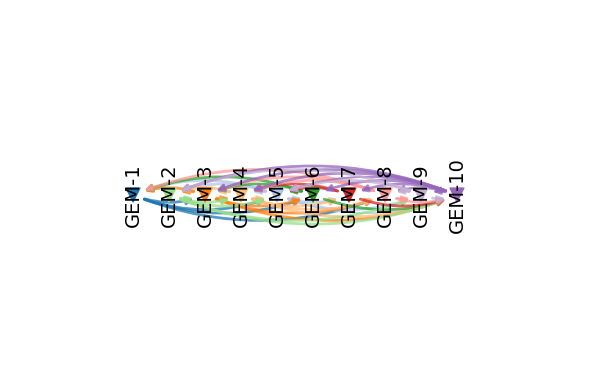

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))
fs.pl.plot_intercellular_flows(adata,
                                flow_network = flow_network,
                                flowsig_network_key = 'flowsig_network',
                                align_mode = 'horizontal',
                                width_scale = 2.0,
                                x_margin_offset = 0.3,
                                y_margin_offset = 0.0,
                                ax=ax)
plt.show()